# BETO Fine-Tuning Acronym Classification


In [1]:
# Fist install the library and download the models from github

!pip install transformers
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

     |████████████████████████████████| 2.3MB 7.4MB/s 
     |████████████████████████████████| 3.3MB 49.8MB/s 
     |████████████████████████████████| 901kB 20.0MB/s 
--2021-05-23 20:59:44--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409871727 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz’

pytorch_weights.tar 100%[===================>] 390.88M  6.30MB/s    in 82s     

2021-05-23 21:01:07 (4.75 MB/s) - ‘pytorch_weights.tar.gz’ saved [409871727/409871727]

--2021-05-23 21:01:07--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request se

In [2]:
#Activating the GPU

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#Installing the Hugging Face PyTorch Interface for Bert
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install -q transformers

     |████████████████████████████████| 133kB 8.6MB/s 
     |████████████████████████████████| 92kB 11.9MB/s 
     |████████████████████████████████| 133kB 50.1MB/s 
     |████████████████████████████████| 7.6MB 45.9MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
ERROR: botocore 1.20.78 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [4]:
#Importing the modules
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertForMaskedLM
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
#Specifying CUDA as the device for Torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Load Data


In [6]:
df = pd.read_csv("train_data_beto.csv", delimiter=',')
df.shape

(6360, 5)

In [10]:
df.sample(10)

,Unnamed: 0,short_form,context,long_form,label
2777,2777,AOC,y proceden de localidades diferentes . La DG e...,albinismo oculocutaneo,1
3152,3152,cm,intestinales . El examen físico y la rutina de...,centimetro agua,0
3501,3501,cc,"parenquimatosa , el catéter Swan-Ganz estaba e...",centimetro cubico,1
3466,3466,mmHg,"µg . kg-1 . min-1 , frecuencia cardíaca de 80 ...",milimetro mercurio,1
1047,1047,kU,"1,4 mg/dL ( 0,6-1,2 ) , LDH 446 U/L ( 0-288 ) ...",kilo unidad,1
6239,6239,mg,; hemofiltro de acrilonitrilo con superficie =...,miligramo,1
1515,1515,FA,al alta con el diagnóstico de infección por Pa...,fosfatasa alcalino,0
2833,2833,h,"anteriormente . En la actualidad , a los 3 mes...",hora,0
972,972,RM,la fosa craneal media derecha con desplazamien...,resonancia magnetico,1
4922,4922,ng,de la exploración normal . En la analítica ini...,nanogramar,1


In [7]:
df = df[['short_form', 'context','long_form', 'label']]

In [8]:
# Adding CLS and SEP tokens at the beginning and end of each LF for BETO
df['sentences'] = df['long_form'].map(lambda x: "[CLS] " + x + " [SEP] ")+df['context'] + ' [SEP]'

In [9]:
df.head()

,short_form,context,long_form,label,sentences
0,PAAF,no invadía estructuras vecinas y con una densi...,puncion aspiracion aguja fino,1,[CLS] puncion aspiracion aguja fino [SEP] no i...
1,PAAF,no invadía estructuras vecinas y con una densi...,puncion aspirativo aguja fino,0,[CLS] puncion aspirativo aguja fino [SEP] no i...
2,RM,y la exploración intraoral fue normal . El res...,resonancia magnetico,1,[CLS] resonancia magnetico [SEP] y la explorac...
3,cm,5*10cm para mejorar el cierre directo . Durant...,centimetro,1,[CLS] centimetro [SEP] 5*10cm para mejorar el ...
4,cm,5*10cm para mejorar el cierre directo . Durant...,centimetro agua,0,[CLS] centimetro agua [SEP] 5*10cm para mejora...


#### Get texts and labels in array form

In [10]:
sentences = df.sentences.values

labels = df.label.values

In [11]:
sentences[:3]

array(['[CLS] puncion aspiracion aguja fino [SEP] no invadía estructuras vecinas y con una densidad grasa . Se realiza la toma de una muestra mediante punción-aspiración con aguja fina ( < start > PAAF < end > que confirmó las sospechas iniciales de lipoma . Se decidió realizar escisión quirúrgica de la tumoración . Se realizó un abordaje a nivel de la línea posterior del cabello , [SEP]',
       '[CLS] puncion aspirativo aguja fino [SEP] no invadía estructuras vecinas y con una densidad grasa . Se realiza la toma de una muestra mediante punción-aspiración con aguja fina ( < start > PAAF < end > que confirmó las sospechas iniciales de lipoma . Se decidió realizar escisión quirúrgica de la tumoración . Se realizó un abordaje a nivel de la línea posterior del cabello , [SEP]',
       '[CLS] resonancia magnetico [SEP] y la exploración intraoral fue normal . El resto de la exploración física fue completamente anodina . Se decide realizar resonancia magnética ( < start > RM < end > cérvico-

### Tokenizer from pre-trained model and pre-process

In [12]:
tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'pun', '##cion', 'aspira', '##cion', 'aguja', 'fino', '[SEP]', 'no', 'invad', '##ía', 'estructuras', 'vecinas', 'y', 'con', 'una', 'densidad', 'grasa', '.', 'Se', 'realiza', 'la', 'toma', 'de', 'una', 'muestra', 'mediante', 'pun', '##ción', '-', 'aspira', '##ción', 'con', 'aguja', 'fina', '(', '[UNK]', 'sta', '##r', '##t', '[UNK]', 'PA', '##A', '##F', '[UNK]', 'end', '[UNK]', 'que', 'confirmó', 'las', 'sospechas', 'iniciales', 'de', 'li', '##po', '##ma', '.', 'Se', 'decidió', 'realizar', 'esc', '##isión', 'quirúr', '##gica', 'de', 'la', 'tumor', '##ación', '.', 'Se', 'realizó', 'un', 'aborda', '##je', 'a', 'nivel', 'de', 'la', 'línea', 'posterior', 'del', 'cabello', ',', '[SEP]']


Transform tokens to index, based on vocabulary

In [13]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
input_ids[0]

array([    4,  5441,  1426, 16757,  1426, 17356, 22549,     5,  1084,
       17951,  1103,  7706, 30479,  1042,  1051,  1108,  6647, 15391,
        1009,  1264,  7379,  1030,  4330,  1008,  1108,  4744,  2696,
        5441,  1119,  1149, 16757,  1119,  1051, 17356, 23045,  1147,
           3, 15326, 30936, 30940,     3, 11389, 30963, 30999,     3,
       15223,     3,  1038, 14308,  1089, 23320, 13312,  1008,  1483,
        1194,  1239,  1009,  1264,  5645,  3335,  1489,  1387, 18959,
        4942,  1008,  1030, 16967,  1086,  1009,  1264,  7074,  1049,
       23794,  1323,  1013,  2153,  1008,  1030,  3351,  6652,  1072,
       10040,  1017,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

Adding 1 to each original token, and 0 to tokens that have been added to fill de max length

In [14]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
attention_masks[0]

### Train, validation split

In [15]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Transform data into tensors

In [16]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [17]:
#batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [18]:
try:
    import transformers
except:
    print("Installing transformers")
    !pip -qq install transformers

## Model

Loading the Hugging Face Beto Uncased Base Model 

In [18]:
# model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = BertForSequenceClassification.from_pretrained("pytorch/", num_labels=2)

# Accessing the model configuration
configuration = model.config
print(configuration)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}



In [19]:
model.cuda()

Some weights of the model checkpoint at pytorch/ were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pytorch/

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Optimizer Grouped Parameters

In [20]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 

optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

Hyperparemeters for the Training Loop 

In [21]:
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Function to calculate the accuracy of our predictions vs labels

In [23]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### The Training Loop 

In [24]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.45152156762570644


Epoch:  25%|██▌       | 1/4 [02:07<06:23, 127.89s/it]

Validation Accuracy: 0.8819196428571429
Train loss: 0.25032739312122654


Epoch:  50%|█████     | 2/4 [04:20<04:18, 129.37s/it]

Validation Accuracy: 0.9024553571428571
Train loss: 0.1891034795023376


Epoch:  75%|███████▌  | 3/4 [06:34<02:10, 130.55s/it]

Validation Accuracy: 0.9073660714285714
Train loss: 0.15618739971193854


Epoch: 100%|██████████| 4/4 [08:47<00:00, 131.79s/it]

Validation Accuracy: 0.9087053571428572


Training Evaluation

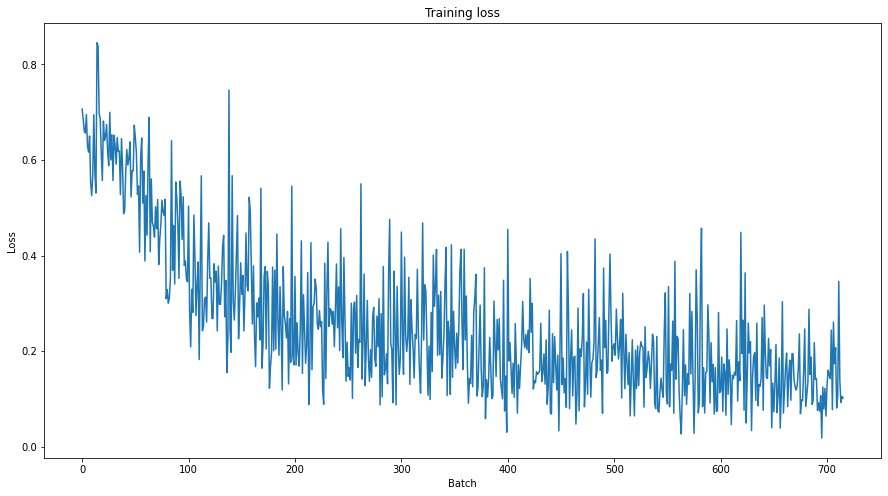

In [40]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Testing

Testing inputs

In [27]:
df_test = pd.read_csv("test_data_beto.csv")

df_test['sentences'] = df_test['long_form'].map(lambda x: "[CLS] " + x + " [SEP] ")+df['context'] + ' [SEP]'

# Create sentence and label lists
sentences_test = df_test.sentences.values

labels_test = df_test.label.values

tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]


MAX_LEN = 128

input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_test:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels_test)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Prediction on test set

In [38]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

Validation Accuracy: 0.9041241496598639
Validation Accuracy: 0.898538961038961
Validation Accuracy: 0.8934394409937888
Validation Accuracy: 0.8874627976190476
Validation Accuracy: 0.8857142857142857
Validation Accuracy: 0.8792925824175823
Validation Accuracy: 0.8721891534391534
Validation Accuracy: 0.8644770408163265
Validation Accuracy: 0.854064039408867
Validation Accuracy: 0.8485119047619047
Validation Accuracy: 0.8473502304147466
Validation Accuracy: 0.8404017857142857
Validation Accuracy: 0.8376623376623377
Validation Accuracy: 0.826811974789916
Validation Accuracy: 0.8290816326530612
Validation Accuracy: 0.8216765873015873
Validation Accuracy: 0.8214285714285714
Validation Accuracy: 0.8203712406015038
Validation Accuracy: 0.8209706959706958
Validation Accuracy: 0.8223214285714284
Validation Accuracy: 0.8182709059233448
Validation Accuracy: 0.8159013605442176
Validation Accuracy: 0.8158222591362125
Validation Accuracy: 0.8143262987012986
Validation Accuracy: 0.8142857142857142
Val

KeyboardInterrupt: ignored

In [ ]:
print(predictions[:3])
print(true_labels[:3])

### Evaluating

In [31]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [33]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.19416711095740663